# Boosting with Haar filters on Mnist

https://www.cs.cmu.edu/~efros/courses/LBMV07/Papers/viola-cvpr-01.pdf

In [1]:
import mnist
import numpy as np
from numpy.random import choice,normal,uniform

In [2]:
X_train, y_train = mnist.load_mnist(dataset="training", path="mnist/" ,return_labels=True, return_indices=False)
X_test, y_test = mnist.load_mnist(dataset="testing", path="mnist/" ,return_labels=True, return_indices=False)

In [3]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)


### Task: discriminating odd numbers vs. even ones
#### Form classes

In [4]:
y_train = np.array([1 if y in [1, 3, 5, 7, 9] else 0 for y in y_train])
y_test = np.array([1 if y in [1, 3, 5, 7, 9] else 0 for y in y_test])

In [5]:
P = np.count_nonzero(y_train)
N = len(y_train)-P
print(N)
print(P)

29492
30508


### Integral images

In [6]:
X_train_int = np.cumsum(np.cumsum(X_train, axis=1),axis=2)
X_test_int = np.cumsum(np.cumsum(X_test, axis=1),axis=2)

### Functions and classes

#### 1-rectangle Haar feature

In [7]:
class Haar_clf():
    def __init__(self,x0, x1, y0, y1, t=-1):
        self.x0 = x0
        self.x1 = x1
        self.y0 = y0
        self.y1 = y1
        self.t = t
        
    def integral_haar_conv(self,ii):
        return ii[:,self.x0, self.y0] + ii[:,self.x1, self.y1] - ii[:,self.x0, self.y1] - ii[:,self.x1, self.y0]
    
    # finds optimal threshold and return error
    def train(self,X_train_int,y_train,w):
        h = self.integral_haar_conv(X_train_int)
        y = y_train.copy()
        y[np.where(y_train==0)] = -1
        order = np.argsort(h)
        error = np.sum(w*(y_train==0))
        errors = np.cumsum(y[order]*w[order])+error
        index_min = np.argmin(errors)
        min_error = errors[index_min]
        self.t = h[order[index_min]]
        o = w*(self.pred(X_train_int) != y_train)
        actual_error = np.count_nonzero(o)/len(o)
        return actual_error

    def pred(self,X):  #X - integral images
        return self.integral_haar_conv(X)>self.t

#### Random search

In [8]:
def slight_shift(x,y,radius):
    x_new = choice(np.arange(max(0,x-radius),min(27,x+radius)))
    y_new = choice(np.arange(max(0,y-radius),min(27,y+radius)))
    return x_new,y_new


def random_search_haar(i_images,y,w,num_iter, radius):
    x0,x1,y0,y1 = choice(27,4)
    haar_clf = Haar_clf(x0,x1,y0,y1)
    error = haar_clf.train(i_images,y,w)
    for _ in range(num_iter):
        x0_new,x1_new = slight_shift(haar_clf.x0,haar_clf.x1,radius)
        y0_new,y1_new = slight_shift(haar_clf.y0,haar_clf.y1,radius)
        haar_clf_new = Haar_clf(x0_new,x1_new,y0_new,y1_new)
        error_new = haar_clf_new.train(i_images,y,w)
        if error_new < error:
            haar_clf = haar_clf_new
            error = error_new
    return error, haar_clf

####  Simulated annealing

In [9]:
def simulated_annealing_haar(i_images,y,w,num_iter,radius=5,Tmax=1,cooling='exp',a=0.9):
    T = Tmax
    x0,x1,y0,y1 = choice(27,4)
    haar_clf = Haar_clf(x0,x1,y0,y1)
    E = haar_clf.train(i_images,y,w)
    for k in range(num_iter):
        x0_new,x1_new,y0_new,y1_new = [x0,x1,y0,y1] + (normal(loc=0.0, scale=radius*np.sqrt(T), size=4))
        x0_new,x1_new,y0_new,y1_new = np.clip([x0_new,x1_new,y0_new,y1_new], 0, 27)
        x0_new,x1_new,y0_new,y1_new = int(x0_new),int(x1_new),int(y0_new),int(y1_new)
        haar_clf_new = Haar_clf(x0_new,x1_new,y0_new,y1_new)
        E_new = haar_clf_new.train(i_images,y,w)
        #updating
        if E_new < E or np.exp((E-E_new)/T)>uniform():
#             print(str(E)+ "  " + str(E_new) + "  " + str(T) +" "+ str(np.exp((E-E_new)/T)))
            haar_clf = haar_clf_new
            E = E_new
            x0,x1,y0,y1 = x0_new,x1_new,y0_new,y1_new
        #cooling
        if cooling == 'cauchy':
            T = Tmax/(1+k)
        elif cooling == 'log':
            T = Tmax/np.log(1+k)
        elif cooling == 'exp':
            T = a*T
        else:
            raise Exception("Error. Cooling must be one of: 'cauchy', 'log', 'exp'.")
    return E, haar_clf

#### Plotting

In [10]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline
def plot_loss(history):
    clear_output(True)
    plt.plot(history,label='loss')
    plt.legend()
    plt.show()

#### Strong classifier

In [43]:
class Strong_clf:
    def __init__(self,weak_clfs={}):
        self.weak_clfs = weak_clfs #dict {weak_clf:alpha}
        self.num_features = len(weak_clfs)
        
    def add(self,weak_clf,alpha):
        self.weak_clfs[weak_clf] = alpha
        
    
    def pred(self,X):
        return (np.sum(np.array([alpha*(weak_clf.pred(X)-0.5) for weak_clf,alpha in self.weak_clfs.items()]),axis=0) >= 0)
    
    
    def pred_nonlinear(self,X):
        return (np.sum(np.array([alpha*(weak_clf.prob(X)) for weak_clf,alpha in self.weak_clfs.items()]),axis=0) >= 0)
        
          
    def prob(self,X):
        return np.tanh(np.sum(np.array([alpha*(weak_clf.pred(X)-0.5) for weak_clf,alpha in self.weak_clfs.items()]),axis=0))
          
    
    def adaboost_with_random_search(self,X_train_int,y_train,num_features,num_iter,radius,plot=True,w=[]):
        self.weak_clfs = {}
        self.num_features = num_features
        P = np.count_nonzero(y_train)
        N = len(y_train)-P
        #initialize weights
        if len(w) == 0:
            w = (y_train == 0)/(2*N) + (y_train == 1)/(2*P)
        i,history = 0, []
        while i < num_features:
            error, haar_clf = random_search_haar(X_train_int,y_train,w,num_iter,radius)
            if error > 0.5:
                continue
            else:
                i += 1
            e = (y_train != haar_clf.pred(X_train_int))
            b = error/(1-error)
#             print("haar classifier error: " + str(error))
            e[np.where(e==0)] = b
            w = w*e
            w = w/np.sum(w)
            self.add(haar_clf,-np.log(b))
            if plot:
                mis = (y_train != self.pred(X_train_int))
                history.append(np.count_nonzero(mis)/len(mis))
                plot_loss(history)
    
            
    def adaboost_with_simulated_annealing(self,X_train_int,y_train,num_features,num_iter,radius,Tmax,cooling='exp',a=0.9,plot=True,w=[]):
        self.weak_clfs = {}
        self.num_features = num_features
        P = np.count_nonzero(y_train)
        N = len(y_train)-P
        #initialize weights
        if len(w) == 0:
            w = (y_train == 0)/(2*N) + (y_train == 1)/(2*P)
        i, history = 0, []
        while i < num_features:
            error, haar_clf = simulated_annealing_haar(X_train_int,y_train,w,num_iter,radius,Tmax,cooling,a)
            if error > 0.5:
                continue
            else:
                i += 1
            e = (y_train != haar_clf.pred(X_train_int))
            b = error/(1-error)
#            print("haar classifier error: " + str(error))
            e[np.where(e==0)] = b
            w = w*e
            w = w/np.sum(w)
            self.add(haar_clf,-np.log(b))
            if plot:
                mis = (y_train != self.pred(X_train_int))
                history.append(np.count_nonzero(mis)/len(mis))
                plot_loss(history)
                
                
    def adaboost_in_adaboost(self,X_train_int,y_train,num_features,num_inner_features,num_iter,radius,plot=True,w=[]):
        self.weak_clfs = {}
        self.num_features = num_features
        P = np.count_nonzero(y_train)
        N = len(y_train)-P
        #initialize weights
        if len(w) == 0:
            w = (y_train == 0)/(2*N) + (y_train == 1)/(2*P)
        i,history = 0, []
        while i < num_features:
            ada_clf = Strong_clf()
            ada_clf.adaboost_with_random_search(X_train_int=X_train_int,y_train=y_train,num_features=num_inner_features,num_iter=num_iter,radius=radius,plot=False,w=w)
            e = (y_train != self.pred_nonlinear(X_train_int))
            error = np.count_nonzero(e)/len(e)
            if error > 0.5:
                continue
            else:
                i += 1
            b = error/(1-error)
#             print("adaboost classifier error: " + str(error))
            e[np.where(e==0)] = b
            w = w*e
            w = w/np.sum(w)
            self.add(ada_clf,-np.log(b))
            if plot:
                mis = (y_train != self.pred_nonlinear(X_train_int))
                history.append(np.count_nonzero(mis)/len(mis))
                plot_loss(history)
        

```

```

```

```

```

```
### Train with random search

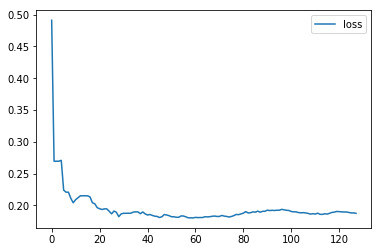

In [30]:
clf = Strong_clf()
clf.adaboost_with_random_search(X_train_int,y_train,128,30,3)

In [31]:
p = (clf.pred(X_train_int) == y_train)
print("Train accuracy: " + str(np.count_nonzero(p)/len(p)))

Train accuracy: 0.8126666666666666


In [32]:
p = (clf.pred(X_test_int) == y_test)
print("Test accuracy: " + str(np.count_nonzero(p)/len(p)))

Test accuracy: 0.8106


### Train with simulated annealing

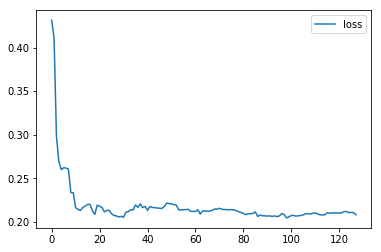

In [129]:
clf = Strong_clf()
clf.adaboost_with_simulated_annealing(X_train_int,y_train,128,40,radius=10,Tmax=1,cooling='exp',a=0.8,plot=True)

In [130]:
p = (clf.pred(X_train_int) == y_train)
print("Train accuracy: " + str(np.count_nonzero(p)/len(p)))

Train accuracy: 0.7917333333333333


In [131]:
p = (clf.pred(X_test_int) == y_test)
print("Test accuracy: " + str(np.count_nonzero(p)/len(p)))

Test accuracy: 0.791


### Boosting in boosting

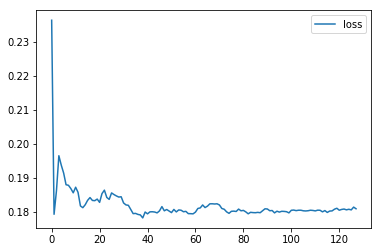

In [44]:
clf = Strong_clf()
clf.adaboost_in_adaboost(X_train_int,y_train,128,8,30,3,plot=True)

In [47]:
p = (clf.pred_nonlinear(X_train_int) == y_train)
print("Train accuracy: " + str(np.count_nonzero(p)/len(p)))

Train accuracy: 0.8191333333333334


In [49]:
p = (clf.pred_nonlinear(X_test_int) == y_test)
print("Test accuracy: " + str(np.count_nonzero(p)/len(p)))

Test accuracy: 0.8138
